In [1]:
import os
import PIL
from PIL import Image
import numpy as np
import cv2

def load_images(folder_path):
    image_list = []

    # List all files in the folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.jpg')][:30]

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(np.array(image_rgb).reshape((128, 128, 3)))

    return image_list
    
folder = 'data/crop_sorted_images'
train_images = load_images(folder)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint

hidden_size = 100
latent_size = 20
input_layer = layers.Input(shape = (128, 128, 3))
flattened = layers.Flatten()(input_layer)
hidden = layers.Dense(hidden_size, activation = 'relu')(flattened)
latent = layers.Dense(latent_size, activation = 'relu')(hidden)
encoder = Model(inputs = input_layer, outputs = latent, name = 'encoder')
encoder.summary()

2024-03-02 21:04:38.524195: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 21:04:38.547415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 21:04:38.547436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 21:04:38.548199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 21:04:38.553046: I tensorflow/core/platform/cpu_feature_guar

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 100)               4915300   
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
Total params: 4917320 (18.76 MB)
Trainable params: 4917320 (18.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-03-02 21:04:39.892362: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-02 21:04:39.915229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-02 21:04:39.915346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
input_layer_decoder = layers.Input(shape = encoder.output.shape)
upsampled = layers.Dense(hidden_size, activation = 'relu')(input_layer_decoder)
upsampled = layers.Dense(encoder.layers[1].output_shape[-1], activation = 'relu')(upsampled)
constructed = layers.Reshape((128, 128, 3))(upsampled)
decoder = Model(inputs = input_layer_decoder, outputs = constructed, name= 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 20)]        0         
                                                                 
 dense_2 (Dense)             (None, None, 100)         2100      
                                                                 
 dense_3 (Dense)             (None, None, 49152)       4964352   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
Total params: 4966452 (18.95 MB)
Trainable params: 4966452 (18.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output))
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 100)               4915300   
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       4966452   
                                                                 
Total params: 9883772 (37.70 MB)
Trainable params: 9883772 (37.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
import os
import PIL
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class ImageDataGenerator(Sequence):
    def __init__(self, folder_path, batch_size):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.file_list = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        self.indexes = np.arange(len(self.file_list))

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images = []

        for i in batch_indexes:
            file_name = self.file_list[i]
            file_path = os.path.join(self.folder_path, file_name)
            image = cv2.imread(file_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            processed_image = np.array(image_rgb).reshape((128, 128, 3)) / 255.0
            batch_images.append(processed_image)

        return np.array(batch_images), np.array(batch_images)

# Set your folder path and batch size
folder = 'data/crop_sorted_images'
batch_size = 16  # Adjust this based on your available memory and batch size preference

# Create an instance of the custom data generator
data_generator = ImageDataGenerator(folder, batch_size)

In [6]:
autoencoder.fit(data_generator, epochs=20, steps_per_epoch=len(data_generator), shuffle=True)

Epoch 1/20


2024-03-02 21:04:40.644100: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-02 21:04:40.861860: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc9f400d2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-02 21:04:40.861877: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-02 21:04:40.865468: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-02 21:04:40.875643: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1709406280.931476  257978 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


904/904 [==============================] - 7s 7ms/step - loss: 0.0548
Epoch 2/20
904/904 [==============================] - 7s 8ms/step - loss: 0.0329
Epoch 3/20
904/904 [==============================] - 9s 9ms/step - loss: 0.0270
Epoch 4/20
904/904 [==============================] - 9s 10ms/step - loss: 0.0245
Epoch 5/20
904/904 [==============================] - 8s 9ms/step - loss: 0.0230
Epoch 6/20
904/904 [==============================] - 9s 10ms/step - loss: 0.0221
Epoch 7/20
904/904 [==============================] - 6s 7ms/step - loss: 0.0216
Epoch 8/20
904/904 [==============================] - 9s 10ms/step - loss: 0.0212
Epoch 9/20
904/904 [==============================] - 9s 10ms/step - loss: 0.0209
Epoch 10/20
904/904 [==============================] - 9s 10ms/step - loss: 0.0207
Epoch 11/20
428/904 [=============>................] - ETA: 4s - loss: 0.0205

KeyboardInterrupt: 

In [ ]:
#autoencoder.fit(X, X, epochs=10, batch_size=1, shuffle=True)

In [7]:
def preproc_img(img):
    return np.array(img).reshape((-1, 128, 128, 3))/255.

1/1 [==============================] - 0s 12ms/step


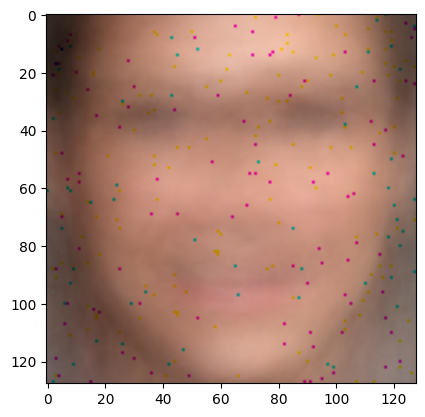

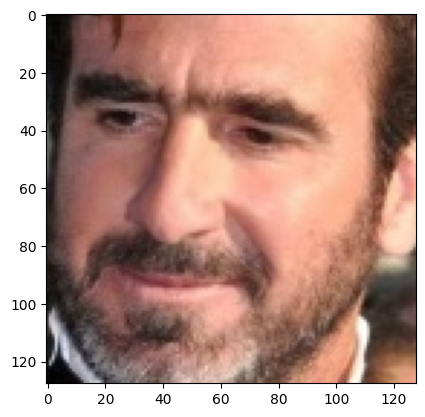

In [11]:
num = 0
plt.imshow(autoencoder.predict(preproc_img(train_images[num])).reshape((128, 128, 3)))
plt.show()
plt.imshow(train_images[num])

In [ ]:
folder = 'data/crop_sorted_images'
file_list = [f for f in os.listdir(folder) if f.endswith('.jpg')][:30]

In [ ]:
img = cv2.imread(folder+'/'+file_list[0])
#img[:, :, 0] = img[:, :, 0]/np.max(img[:, :, 0])
#img[:, :, 1] = img[:, :, 1]/np.max(img[:, :, 1])
#img[:, :, 2] = img[:, :, 2]/np.max(img[:, :, 2])

In [ ]:
import cv2import matplotlib.pyplot as plt
# Завантаження зображення у форматі BGR за допомогою OpenCV
image_bgr = cv2.imread('шлях_до_зображення.jpg')  # Замініть це на свій шлях до зображення
# Перетворення зображення з BGR в RGBimage_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# Відображення зображення у форматі RGB
plt.imshow(image_rgb)plt.axis('off')
plt.show()

In [ ]:
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [13]:
autoencoder.save('autoencoder.keras')